<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
</center>
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://goo.gl/rvvZiR).**

In [98]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz, DecisionTreeRegressor

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

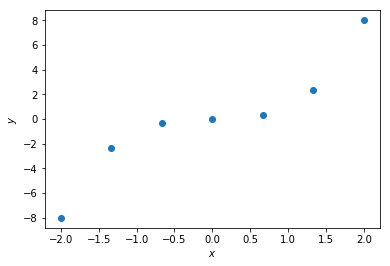

In [68]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график.

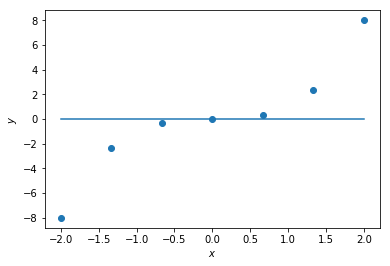

In [21]:
plt.scatter(X, y)
plt.step(X, np.full((y.shape[0], 1), y.mean()))
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

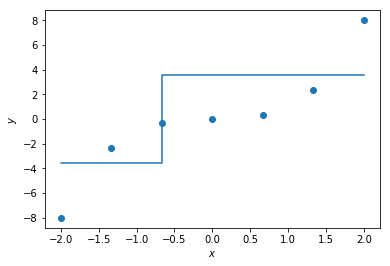

In [20]:
def tree(x):
    if x < 0:
        return y[y < 0].mean()
    else:
        return y[y > 0].mean()

plt.scatter(X, y)
plt.step(X, [tree(x) for x in X])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [145]:
def variance(y):
    return 1. / len(y) * ((y - y.sum()) ** 2).sum()

def regression_var_criterion(X, y, t):
    return y.var() - (X < t).sum() / len(X) * y[X < t].var() - (X >= t).sum() / len(X) * y[X >= t].var()

In [94]:
variance(y)

19.916127767979617

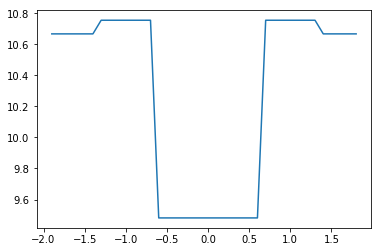

In [144]:
t = np.arange(-1.9, 1.9, 0.1)
plt.plot(t, [regression_var_criterion(X, y, r) for r in t])

In [122]:
tree = DecisionTreeRegressor(max_depth=2)
tree.fit(np.array([X]).T, y.T)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [123]:
export_graphviz(tree, out_file='regression.dot', filled=True)
!dot -Tpng 'regression.dot' -o 'regression.png'

<img src='regression.png'>

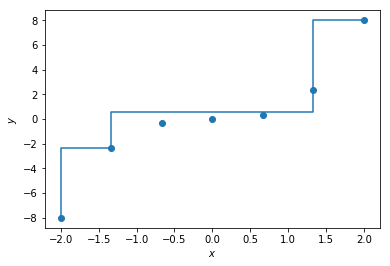

In [140]:
plt.scatter(X, y)
plt.step(X, tree.predict(np.array([X]).T))
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- **Нет**

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

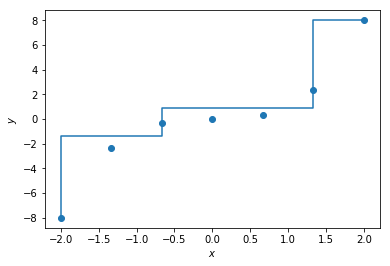

In [138]:
def tree_result(x):
    if x < 0:
        if x < -1.5:
            return y[X < -1.5].mean()
        else:
            return y[(X < 0) & (X >= -1.5)].mean()
    else:
        if x < 1.5:
            return y[(X < 1.5) & (X >= 0)].mean()
        else:
            return y[X >= 1.5].mean()

plt.scatter(X, y)
plt.step(X, [tree_result(x) for x in X])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

**<font color='red'>Вопрос 2.</font> Из скольки отрезков состоит график, изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- **6**
- 7
- 8

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [265]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [167]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах", а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`.

In [181]:
df['age_year'] = df['age'] / 365.25

In [182]:
c = pd.get_dummies(df['cholesterol'])
c.columns = ['cholesterol_1', 'cholesterol_2', 'cholesterol_3']

In [183]:
g = pd.get_dummies(df['gluc'])
g.columns = ['gluc_1', 'gluc_2', 'gluc_3']

In [171]:
df = pd.concat([df, c, g], axis=1)

In [185]:
df.drop(['cholesterol', 'gluc', 'age'], axis=1, inplace=True);

In [186]:
y = df['cardio']
df.drop('cardio', axis=1, inplace=True)

Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [187]:
X_train, X_valid, y_train, y_valid = train_test_split(df, y, test_size=0.3, random_state=17)

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [247]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best')

In [194]:
export_graphviz(tree, out_file='q3.dot', filled=True, feature_names=X_train.columns)
!dot -Tpng 'q3.dot' -o 'q3.png'

<img src='q3.png'>

**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- **age, ap_hi, chol=3**

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [249]:
from sklearn.metrics import accuracy_score
tree_old_acc = accuracy_score(tree.predict(X_valid), y_valid)

Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [250]:
tree_params = {'max_depth': list(range(2, 11))}

tree = DecisionTreeClassifier(random_state=17)
tree_grid = GridSearchCV(tree, param_grid=tree_params, cv=5)
tree_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

/home/ivank/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


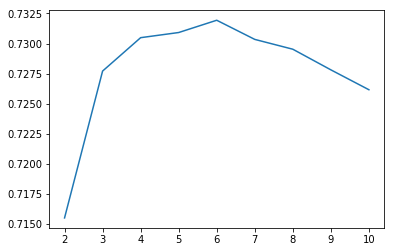

In [251]:
results = [x.mean_validation_score for x in tree_grid.grid_scores_]
plt.plot(list(range(2, 11)), results)

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [252]:
predict = tree_grid.best_estimator_.predict(X_valid)
tree_new_acc = accuracy_score(predict, y_valid)

In [253]:
(tree_new_acc - tree_old_acc) / tree_old_acc * 100

0.62718690169670022

**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева четкий пик, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке?**
- да, да
- **да, нет**
- нет, да
- нет, нет

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках.

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- Верхнее артериальное давление от 140 до 160 (мм рт.ст.)
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [270]:
age_year = df['age'] / 365.25

age45_50 = (age_year >= 45) & (age_year < 50)
age50_55 = (age_year >= 50) & (age_year < 55)
age55_60 = (age_year >= 55) & (age_year < 60)
age60_65 = (age_year >= 60) & (age_year < 65)

ap_hi_120_140 = (df.ap_hi >= 120) & (df.ap_hi < 140)
ap_hi_140_160 = (df.ap_hi >= 140) & (df.ap_hi < 160)
ap_hi_160_180 = (df.ap_hi >= 160) & (df.ap_hi < 180)

c = pd.get_dummies(df['cholesterol'])
c.columns = ['cholesterol_1', 'cholesterol_2', 'cholesterol_3']

male = df['gender'].map({1: 0, 2: 1})

y = df['cardio']

In [271]:
data = pd.concat([
        male,
        age45_50,
        age50_55,
        age55_60,
        age60_65,
        ap_hi_120_140,
        ap_hi_140_160,
        ap_hi_160_180,
        df.smoke,
        c], axis=1)

In [274]:
data.columns = ['male',
                'age45_50',
                'age50_55', 
                'age55_60', 
                'age60_65', 
                'ap_hi_120_140', 
                'ap_hi_140_160',
                'ap_hi_160_180',
                'smoke',
                'c1',
                'c2',
                'c3']

In [277]:
cardio_tree = DecisionTreeClassifier(max_depth=3, random_state=17)
cardio_tree.fit(data, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best')

In [282]:
cardio_tree.feature_importances_

array([  0.00000000e+00,   0.00000000e+00,   2.69702426e-04,
         4.97059348e-04,   0.00000000e+00,   0.00000000e+00,
         5.80389328e-01,   2.48501900e-01,   5.35978783e-05,
         4.57631104e-04,   0.00000000e+00,   1.69830781e-01])

In [284]:
export_graphviz(cardio_tree, out_file='q5.dot', filled=True, feature_names=data.columns)
!dot -Tpng 'q5.dot' -o 'q5.png'

<img src='q5.png'>